In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from scipy.stats import spearmanr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional

(26304, 12)
           Gasoline        Diesel  ...    NOx_Target     CO_Traget
count  26304.000000  26304.000000  ...  26304.000000  26304.000000
mean    4923.868955    640.408797  ...     92.176075   2342.513856
std     3370.018507    386.742127  ...     96.524148   2065.708431
min      316.000000     21.000000  ...      2.910000     48.500000
25%     2126.000000    314.000000  ...     31.675750   1250.000000
50%     4523.000000    629.000000  ...     60.400000   1790.000000
75%     7797.000000    945.000000  ...    115.000000   2690.000000
max    14364.000000   1541.000000  ...   1090.000000  38300.000000

[8 rows x 12 columns]


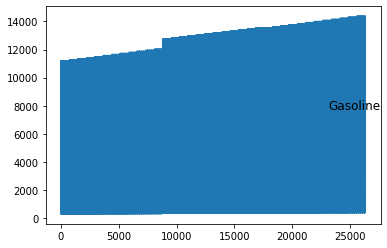

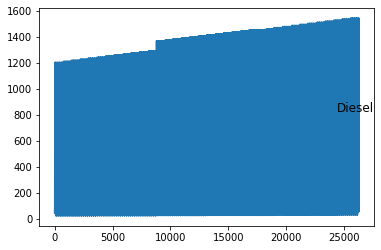

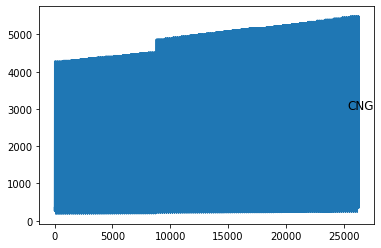

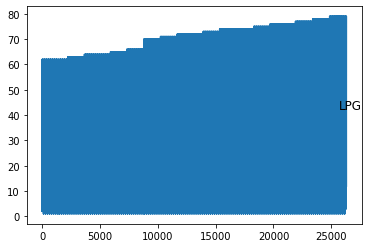

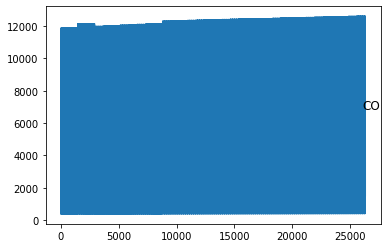

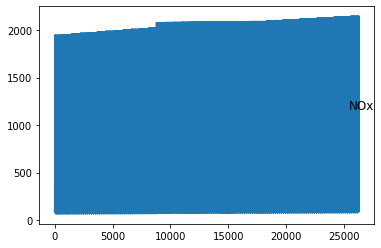

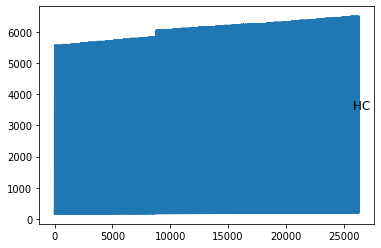

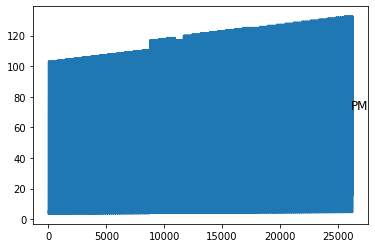

In [2]:
dataframe = read_csv('/content/drive/MyDrive/inno/data.csv', header=0, index_col=0)
dataframe.drop(['Atm Pressure',	'Temperature',	'Relative Humidity',	'Wind Direction',	'Wind Velocity',	'Visibility',	'Cloud Cover',	'Rainfall',	'Sun Shine',	'Solar Insulation',	'Stability Class',	'Mixing Height'],axis=1, inplace=True)
print(dataframe.shape)
print(dataframe.describe())
dataset = dataframe.values
def ploter(groups):
  i = 1
  for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(dataset[:, group])
    pyplot.title(dataframe.columns[group], y=0.5, loc='right')
    i += 1
  pyplot.show()
for i in range(0,8):
    group = [i]
    ploter(group)

In [3]:
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[ 524.     ,   68.     ,  351.     , ...,  229.     ,  147.     ,
        3840.     ],
       [ 316.     ,   41.     ,  264.     , ...,  228.23685,  149.     ,
        3490.     ],
       [ 524.     ,  100.     ,  391.     , ...,  227.47368,   92.1    ,
        2970.     ],
       ...,
       [3075.     ,  511.     , 1375.     , ...,  145.     ,   38.3    ,
         991.667  ],
       [2401.     ,  369.     ,  739.     , ...,  146.     ,   37.     ,
         923.333  ],
       [1728.     ,  226.     ,  550.     , ...,  141.     ,   56.7    ,
         855.     ]], dtype=float32)

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
data = np.concatenate((dataset[:,0:8], dataset[:,8:9]), axis=1)
print(data.shape)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
print(reframed.shape)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())

(26304, 9)
(26303, 18)
(26303, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t-1)  var9(t-1)   var1(t)
1   0.014806   0.030921   0.031674  ...   0.015478   0.014060  0.000000
2   0.000000   0.013158   0.015271  ...   0.000000   0.013539  0.014806
3   0.014806   0.051974   0.039216  ...   0.018289   0.013594  0.070971
4   0.070971   0.124342   0.083145  ...   0.074889   0.013539  0.127136
5   0.127136   0.197368   0.127074  ...   0.131481   0.015019  0.183442

[5 rows x 10 columns]


In [6]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 9) (21042,) (5261, 1, 9) (5261,)


Epoch 1/73
281/281 - 7s - loss: 0.0923 - val_loss: 0.0925
Epoch 2/73
281/281 - 1s - loss: 0.0822 - val_loss: 0.0907
Epoch 3/73
281/281 - 1s - loss: 0.0811 - val_loss: 0.0892
Epoch 4/73
281/281 - 1s - loss: 0.0801 - val_loss: 0.0883
Epoch 5/73
281/281 - 1s - loss: 0.0795 - val_loss: 0.0878
Epoch 6/73
281/281 - 1s - loss: 0.0792 - val_loss: 0.0876
Epoch 7/73
281/281 - 1s - loss: 0.0788 - val_loss: 0.0872
Epoch 8/73
281/281 - 1s - loss: 0.0783 - val_loss: 0.0869
Epoch 9/73
281/281 - 1s - loss: 0.0778 - val_loss: 0.0865
Epoch 10/73
281/281 - 1s - loss: 0.0772 - val_loss: 0.0859
Epoch 11/73
281/281 - 1s - loss: 0.0766 - val_loss: 0.0852
Epoch 12/73
281/281 - 1s - loss: 0.0759 - val_loss: 0.0848
Epoch 13/73
281/281 - 1s - loss: 0.0752 - val_loss: 0.0838
Epoch 14/73
281/281 - 1s - loss: 0.0745 - val_loss: 0.0830
Epoch 15/73
281/281 - 1s - loss: 0.0737 - val_loss: 0.0823
Epoch 16/73
281/281 - 1s - loss: 0.0731 - val_loss: 0.0817
Epoch 17/73
281/281 - 1s - loss: 0.0727 - val_loss: 0.0812
Epoch 

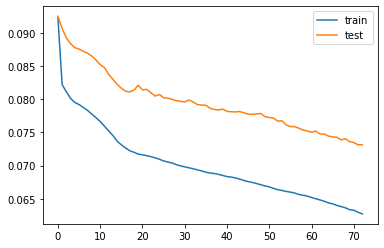

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=73, batch_size=75, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1661.089
Test CC(Corelation Coefficient)     : 0.927
Test PB(Percentage Bias)            : 0.079
Test NSE(Nash Sutcliffe Efficiency) : 0.794


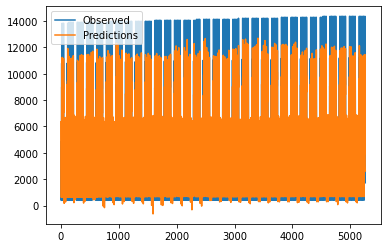

In [8]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [9]:
data = np.concatenate((dataset[:,0:8], dataset[:,9:10]), axis=1)
print(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


[[ 524.        68.       351.      ...  259.155      5.486    229.     ]
 [ 316.        41.       264.      ...  158.559      3.487    228.23685]
 [ 524.       100.       391.      ...  229.421      5.849    227.47368]
 ...
 [3075.       511.      1375.      ... 1216.352     30.388    145.     ]
 [2401.       369.       739.      ...  961.742     22.422    146.     ]
 [1728.       226.       550.      ...  734.224     15.984    141.     ]]
(26303, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t-1)  var9(t-1)   var1(t)
1   0.014806   0.030921   0.031674  ...   0.015478   0.213692  0.000000
2   0.000000   0.013158   0.015271  ...   0.000000   0.212961  0.014806
3   0.014806   0.051974   0.039216  ...   0.018289   0.212230  0.070971
4   0.070971   0.124342   0.083145  ...   0.074889   0.211499  0.127136
5   0.127136   0.197368   0.127074  ...   0.131481   0.210768  0.183442

[5 rows x 10 columns]


In [10]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 9) (21042,) (5261, 1, 9) (5261,)


Epoch 1/72
264/264 - 6s - loss: 0.0909 - val_loss: 0.0930
Epoch 2/72
264/264 - 1s - loss: 0.0815 - val_loss: 0.0904
Epoch 3/72
264/264 - 1s - loss: 0.0803 - val_loss: 0.0902
Epoch 4/72
264/264 - 1s - loss: 0.0795 - val_loss: 0.0889
Epoch 5/72
264/264 - 1s - loss: 0.0793 - val_loss: 0.0884
Epoch 6/72
264/264 - 1s - loss: 0.0790 - val_loss: 0.0962
Epoch 7/72
264/264 - 1s - loss: 0.0788 - val_loss: 0.0947
Epoch 8/72
264/264 - 1s - loss: 0.0784 - val_loss: 0.0880
Epoch 9/72
264/264 - 1s - loss: 0.0778 - val_loss: 0.0884
Epoch 10/72
264/264 - 1s - loss: 0.0782 - val_loss: 0.0911
Epoch 11/72
264/264 - 1s - loss: 0.0764 - val_loss: 0.0870
Epoch 12/72
264/264 - 1s - loss: 0.0767 - val_loss: 0.0856
Epoch 13/72
264/264 - 1s - loss: 0.0758 - val_loss: 0.0833
Epoch 14/72
264/264 - 1s - loss: 0.0740 - val_loss: 0.0892
Epoch 15/72
264/264 - 1s - loss: 0.0733 - val_loss: 0.0817
Epoch 16/72
264/264 - 1s - loss: 0.0729 - val_loss: 0.0813
Epoch 17/72
264/264 - 1s - loss: 0.0726 - val_loss: 0.0811
Epoch 

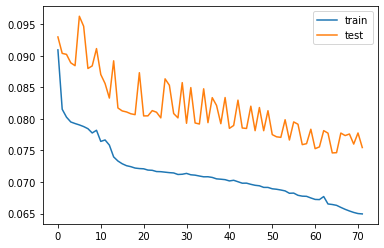

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1799.690
Test CC(Corelation Coefficient)     : 0.909
Test PB(Percentage Bias)            : 0.052
Test NSE(Nash Sutcliffe Efficiency) : 0.758


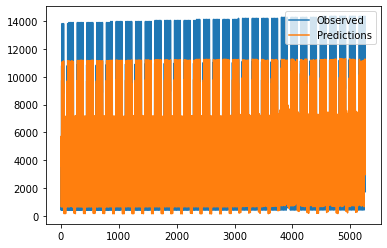

In [12]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [13]:
data = np.concatenate((dataset[:,0:8], dataset[:,10:11]), axis=1)
print(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


[[ 524.      68.     351.    ...  259.155    5.486  147.   ]
 [ 316.      41.     264.    ...  158.559    3.487  149.   ]
 [ 524.     100.     391.    ...  229.421    5.849   92.1  ]
 ...
 [3075.     511.    1375.    ... 1216.352   30.388   38.3  ]
 [2401.     369.     739.    ...  961.742   22.422   37.   ]
 [1728.     226.     550.    ...  734.224   15.984   56.7  ]]
(26303, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t-1)  var9(t-1)   var1(t)
1   0.014806   0.030921   0.031674  ...   0.015478   0.132547  0.000000
2   0.000000   0.013158   0.015271  ...   0.000000   0.134386  0.014806
3   0.014806   0.051974   0.039216  ...   0.018289   0.082045  0.070971
4   0.070971   0.124342   0.083145  ...   0.074889   0.073950  0.127136
5   0.127136   0.197368   0.127074  ...   0.131481   0.067051  0.183442

[5 rows x 10 columns]


In [14]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 9) (21042,) (5261, 1, 9) (5261,)


Epoch 1/72
121/121 - 6s - loss: 0.1008 - val_loss: 0.0960
Epoch 2/72
121/121 - 1s - loss: 0.0836 - val_loss: 0.0923
Epoch 3/72
121/121 - 1s - loss: 0.0815 - val_loss: 0.0908
Epoch 4/72
121/121 - 1s - loss: 0.0803 - val_loss: 0.0898
Epoch 5/72
121/121 - 1s - loss: 0.0796 - val_loss: 0.0892
Epoch 6/72
121/121 - 1s - loss: 0.0791 - val_loss: 0.0881
Epoch 7/72
121/121 - 1s - loss: 0.0788 - val_loss: 0.0881
Epoch 8/72
121/121 - 1s - loss: 0.0786 - val_loss: 0.0887
Epoch 9/72
121/121 - 1s - loss: 0.0785 - val_loss: 0.0880
Epoch 10/72
121/121 - 1s - loss: 0.0784 - val_loss: 0.0878
Epoch 11/72
121/121 - 1s - loss: 0.0782 - val_loss: 0.0878
Epoch 12/72
121/121 - 1s - loss: 0.0781 - val_loss: 0.0875
Epoch 13/72
121/121 - 1s - loss: 0.0781 - val_loss: 0.0874
Epoch 14/72
121/121 - 1s - loss: 0.0779 - val_loss: 0.0873
Epoch 15/72
121/121 - 1s - loss: 0.0778 - val_loss: 0.0873
Epoch 16/72
121/121 - 1s - loss: 0.0777 - val_loss: 0.0870
Epoch 17/72
121/121 - 1s - loss: 0.0776 - val_loss: 0.0868
Epoch 

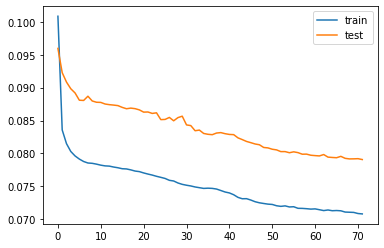

In [15]:
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1817.819
Test CC(Corelation Coefficient)     : 0.905
Test PB(Percentage Bias)            : 0.056
Test NSE(Nash Sutcliffe Efficiency) : 0.753


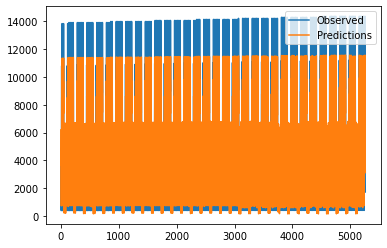

In [16]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [17]:
z =  dataset[:,11]
z = z.reshape(z.shape[0],1)
data = np.concatenate((dataset[:,0:8],z), axis=1)
print(data.shape)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


(26304, 9)
(26303, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t-1)  var9(t-1)   var1(t)
1   0.014806   0.030921   0.031674  ...   0.015478   0.099120  0.000000
2   0.000000   0.013158   0.015271  ...   0.000000   0.089970  0.014806
3   0.014806   0.051974   0.039216  ...   0.018289   0.076376  0.070971
4   0.070971   0.124342   0.083145  ...   0.074889   0.071932  0.127136
5   0.127136   0.197368   0.127074  ...   0.131481   0.064612  0.183442

[5 rows x 10 columns]


In [18]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 9) (21042,) (5261, 1, 9) (5261,)


Epoch 1/69
222/222 - 6s - loss: 0.0932 - val_loss: 0.0925
Epoch 2/69
222/222 - 1s - loss: 0.0810 - val_loss: 0.0898
Epoch 3/69
222/222 - 1s - loss: 0.0796 - val_loss: 0.0884
Epoch 4/69
222/222 - 1s - loss: 0.0792 - val_loss: 0.0882
Epoch 5/69
222/222 - 1s - loss: 0.0788 - val_loss: 0.0877
Epoch 6/69
222/222 - 1s - loss: 0.0786 - val_loss: 0.0875
Epoch 7/69
222/222 - 1s - loss: 0.0784 - val_loss: 0.0872
Epoch 8/69
222/222 - 1s - loss: 0.0783 - val_loss: 0.0871
Epoch 9/69
222/222 - 1s - loss: 0.0781 - val_loss: 0.0869
Epoch 10/69
222/222 - 1s - loss: 0.0779 - val_loss: 0.0867
Epoch 11/69
222/222 - 1s - loss: 0.0777 - val_loss: 0.0867
Epoch 12/69
222/222 - 1s - loss: 0.0775 - val_loss: 0.0865
Epoch 13/69
222/222 - 1s - loss: 0.0773 - val_loss: 0.0859
Epoch 14/69
222/222 - 1s - loss: 0.0771 - val_loss: 0.0856
Epoch 15/69
222/222 - 1s - loss: 0.0768 - val_loss: 0.0851
Epoch 16/69
222/222 - 1s - loss: 0.0764 - val_loss: 0.0847
Epoch 17/69
222/222 - 1s - loss: 0.0761 - val_loss: 0.0843
Epoch 

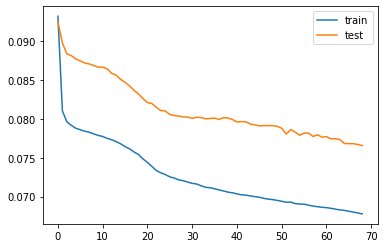

In [19]:
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=69, batch_size=95, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1791.526
Test CC(Corelation Coefficient)     : 0.919
Test PB(Percentage Bias)            : 0.065
Test NSE(Nash Sutcliffe Efficiency) : 0.760


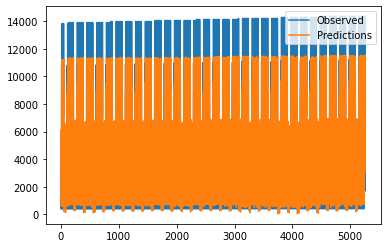

In [20]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()